In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tensorflow as tf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

In [2]:
# load hairpin data
data_path = '../data_peter/random_sequences_with_custom_hl.hdf5'
with h5py.File(data_path) as dataset:
    X_train_seq = np.expand_dims(np.array(dataset['train_seq']).transpose([0, 2, 1]), axis=2)
    X_train_struct = np.expand_dims(np.array(dataset['train_structures']).transpose([0, 2, 1]), axis=2)
    Y_train = np.expand_dims(np.array(dataset['train_targets']), axis=1)
    X_test_seq = np.expand_dims(np.array(dataset['test_seq']).transpose([0, 2, 1]), axis=2)
    X_test_struct = np.expand_dims(np.array(dataset['test_structures']).transpose([0, 2, 1]), axis=2)
    Y_test = np.expand_dims(np.array(dataset['test_targets']), axis=1)

num_data, seq_length, _, num_alphabet = X_train_seq.shape

# get validation set from training set
valid_frac = 0.2
N = len(X_train_seq)
split_index = int(N*valid_frac)
shuffle = np.random.permutation(N)

# put in a dictionary for deepomics
train = {'inputs': X_train_seq[shuffle[split_index:]], 
         'targets': Y_train[shuffle[split_index:]]}
valid = {'inputs': X_train_seq[shuffle[:split_index]], 
         'targets': Y_train[shuffle[:split_index]]}
test = {'inputs': X_test_seq, 'targets': Y_test}



In [3]:
def cnn_model(input_shape, output_shape):

    # create model
    layer1 = {'layer': 'input', #41
            'input_shape': input_shape
            }
    layer2 = {'layer': 'conv1d',
            'num_filters': 96,
            'filter_size': input_shape[1]-29,
            'norm': 'batch',
            'activation': 'relu',
            'dropout': 0.3,
            'padding': 'VALID',
            }
    layer3 = {'layer': 'conv1d_residual',
            'filter_size': 5,
            'function': 'relu',
            'dropout_block': 0.1,
            'dropout': 0.3,
            'mean_pool': 10,
            }
    layer4 = {'layer': 'conv1d',
            'num_filters': 196,
            'filter_size': 3,
            'norm': 'batch',
            'activation': 'relu',
            'dropout': 0.5,
            'padding': 'VALID',
            }
    layer5 = {'layer': 'dense',
            'num_units': output_shape[1],
            'activation': 'sigmoid'
            }

    model_layers = [layer1, layer2, layer3, layer4, layer5]

    # optimization parameters
    optimization = {"objective": "binary",
                  "optimizer": "adam",
                  "learning_rate": 0.0003,
                  "l2": 1e-5,
                  #"label_smoothing": 0.05,
                  #"l1": 1e-6,
                  }
    return model_layers, optimization

tf.reset_default_graph()

# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = '../results/trial_peter'
param_path = os.path.join(save_path, 'hairpin_steffan')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

In [4]:
# look at the shapes of each layer
nnmodel.inspect_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 41, 1, 4)
layer2: conv1d_0
(?, 30, 1, 96)
layer3: conv1d_0_batch
(?, 30, 1, 96)
layer4: conv1d_0_active
(?, 30, 1, 96)
layer5: conv1d_0_dropout
(?, 30, 1, 96)
layer6: conv1d_residual_0_1resid
(?, 30, 1, 96)
layer7: conv1d_residual_0_1resid_norm
(?, 30, 1, 96)
layer8: conv1d_residual_0_1resid_active
(?, 30, 1, 96)
layer9: conv1d_residual_0_dropout1
(?, 30, 1, 96)
layer10: conv1d_residual_0_2resid
(?, 30, 1, 96)
layer11: conv1d_residual_0_2resid_norm
(?, 30, 1, 96)
layer12: conv1d_residual_0_resid_sum
(?, 30, 1, 96)
layer13: conv1d_residual_0_resid
(?, 30, 1, 96)
layer14: conv1d_residual_0_meanpool
(?, 3, 1, 96)
layer15: conv1d_residual_0_dropout
(?, 3, 1, 96)
layer16: conv1d_1
(?, 1, 1, 196)
layer17: conv1d_1_batch
(?, 1, 1, 196)
layer18: conv1d_1_active
(?, 1, 1, 196)
layer19: conv1d_1_dropout


In [5]:
# initialize session
sess = utils.initialize_session()

In [6]:
# set best parameters
nntrainer.set_best_parameters(sess)

# test model
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')

loading model from:  ../results/trial_peter/hairpin_steffan_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/trial_peter/hairpin_steffan_best.ckpt
  test  loss:		0.04078
  test  accuracy:	0.99408+/-0.00000
  test  auc-roc:	0.99971+/-0.00000
  test  auc-pr:		0.99921+/-0.00000


In [7]:
#Get Predictions

# calculate activations
predictionsoutput = nntrainer.get_activations(sess, test, layer='output')
predictionslogits = nntrainer.get_activations(sess, test, layer='dense_0_bias')

# Analysis

### Perform a first order mutagenesis on the highest scored test sequence

In [9]:
# sort activations
plot_index = np.argsort(predictionsoutput[:,0])[::-1]

# saliency parameters  <-- neccessary because we need to rebuild graph using different gradient ops
params = {'genome_model': cnn_model, 
          'input_shape': input_shape, 
          'output_shape': output_shape, 
          'optimization': optimization,
          'model_path': param_path+'_best.ckpt',
         }

X = np.expand_dims(test['inputs'][plot_index[0]], axis=0)

In [10]:
#Mutate the sequence

import mutagenesis_functions as mf

plot_index = np.argsort(predictionsoutput[:,0])[::-1]
X = np.expand_dims(test['inputs'][plot_index[0]], axis=0)

X_mut = mf.mutate(X, X.shape[1], X.shape[3])
mutations = {'inputs': X_mut, 'targets': Y_test[:X_mut.shape[0]]}

# initialize session
sess = utils.initialize_session()

# set best parameters
nntrainer.set_best_parameters(sess)

#Get output activations for the mutations
mut_predictionslogits = nntrainer.get_activations(sess, mutations, layer='dense_0_bias')
mut_predictionsoutput= nntrainer.get_activations(sess, mutations, layer='output')

loading model from:  ../results/trial_peter/hairpin_steffan_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/trial_peter/hairpin_steffan_best.ckpt


/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


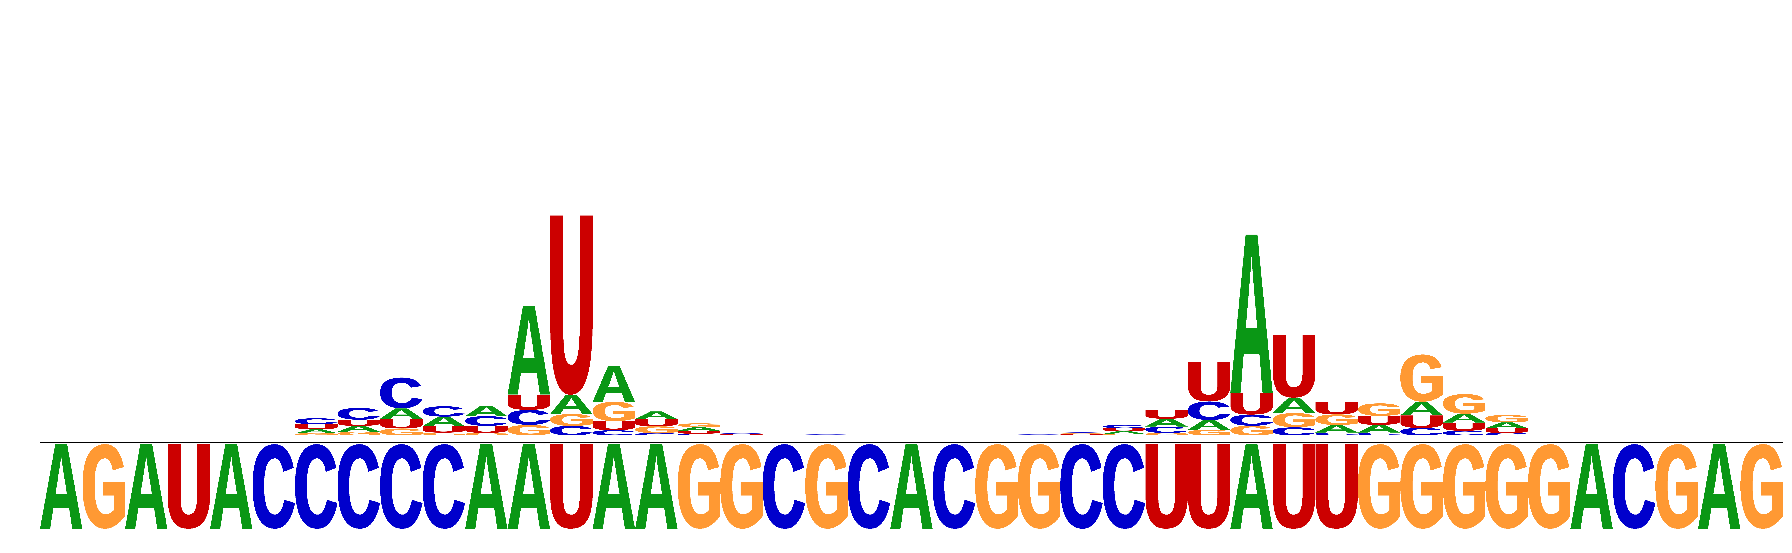

In [10]:
#Look at the logits to see if we can still recapitulate the saliency

#shape the predictions of the mutations into the shape of a heatmap
heat_mut = mut_predictionslogits.reshape(X.shape[1],4).T

#normaliza the data so that it will make more sense

#normalize the heat map rearrangement by minusing it by the true prediction score of that test sequence
norm_heat_mut = heat_mut - predictionslogits[plot_index[0]]
norm_heat_mut = utils.normalize_pwm(norm_heat_mut, factor=4)

plt.figure(figsize=(25,10))
visualize.plot_seq_pos_saliency(np.squeeze(X).T, 
                                        norm_heat_mut, 
                                        alphabet='rna', 
                                        nt_width=400)

loading model from:  results/trial/hairpin_best.ckpt
INFO:tensorflow:Restoring parameters from results/trial/hairpin_best.ckpt


/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


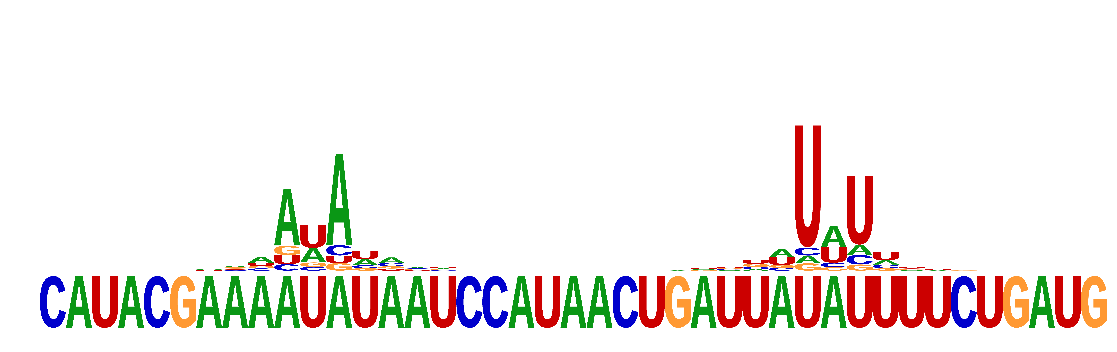

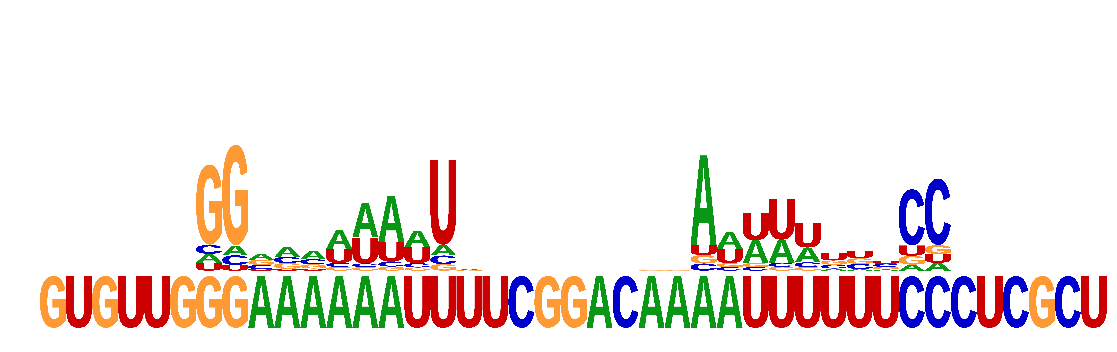

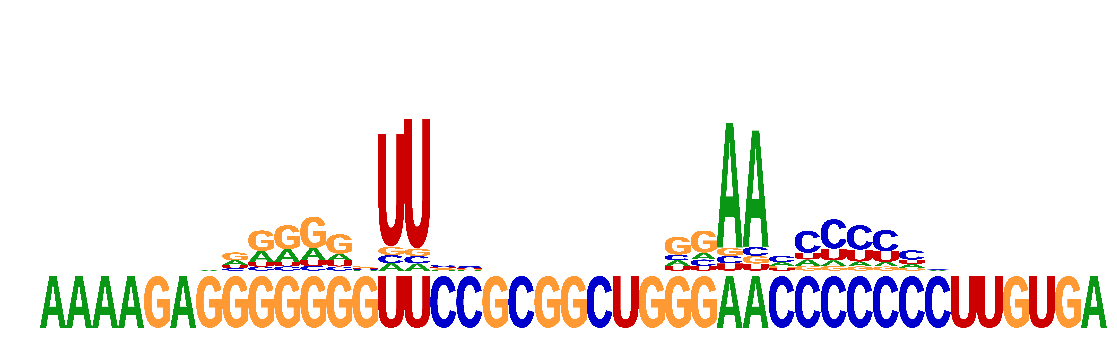

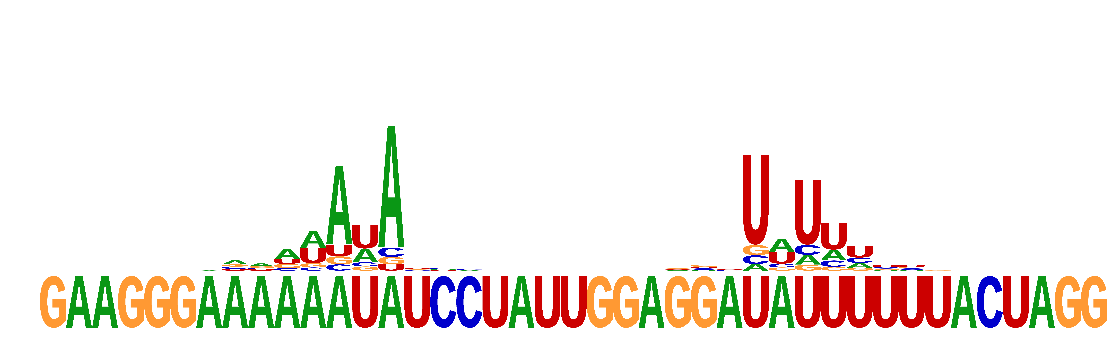

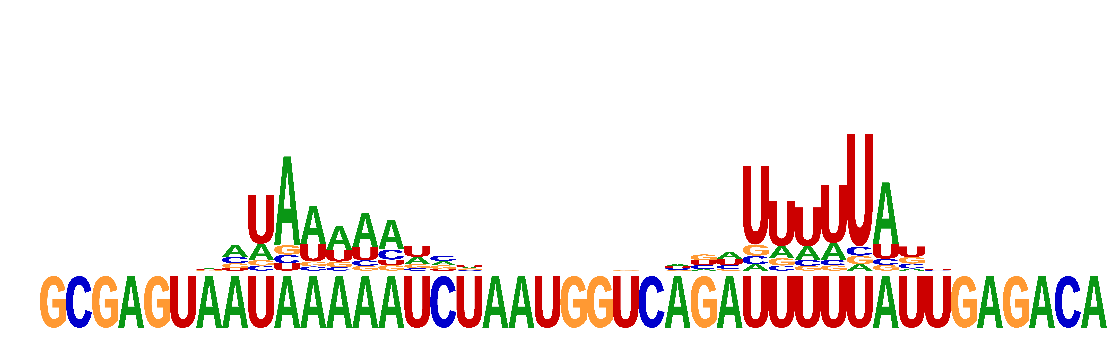

In [103]:
# initialize session
sess = utils.initialize_session()

# set best parameters
nntrainer.set_best_parameters(sess)

num_plots = 5
for index in plot_index[:num_plots]:

    # get a test sequence
    X = np.expand_dims(test['inputs'][index], axis=0)

    X_mut = mf.mutate(X, X.shape[1], X.shape[3])
    mutations = {'inputs': X_mut, 'targets': Y_test[:X_mut.shape[0]]}
    
    #Get output activations for the mutations
    mut_predictionslogits = nntrainer.get_activations(sess, mutations, layer='dense_0_bias')
    
    #shape the predictions of the mutations into the shape of a heatmap
    heat_mut = mut_predictionslogits.reshape(X.shape[1],4).T
    
    #normalize the heat map rearrangement by minusing it by the true prediction score of that test sequence
    norm_heat_mut = heat_mut - predictionslogits[plot_index[0]]
    norm_heat_mut = utils.normalize_pwm(norm_heat_mut, factor=4)
    
    plt.figure(figsize=(25,5))
    visualize.plot_seq_pos_saliency(np.squeeze(X).T, 
                                        norm_heat_mut, 
                                        alphabet='rna', 
                                        nt_width=400)

## Perform a Second Order Mutagenesis

In [10]:
# sort activations
plot_index = np.argsort(predictionsoutput[:,0])[::-1]

# saliency parameters  <-- neccessary because we need to rebuild graph using different gradient ops
params = {'genome_model': cnn_model, 
          'input_shape': input_shape, 
          'output_shape': output_shape, 
          'optimization': optimization,
          'model_path': param_path+'_best.ckpt',
         }

X = np.expand_dims(test['inputs'][plot_index[0]], axis=0)

In [11]:
#Mutate the sequence

import mutagenesis_functions as mf

X_mutsecorder = mf.double_mutate(X, X.shape[1], X.shape[3])

#reshape the 6D tensor into a 4D tensor that the model can test
X_mutsecorder_reshape = np.reshape(X_mutsecorder, (X.shape[1]*X.shape[1]*16, X.shape[1], 1, 4))
print (X_mutsecorder_reshape.shape)

mutations = {'inputs': X_mutsecorder_reshape, 'targets': Y_test[:X_mutsecorder_reshape.shape[0]]}

# initialize session
sess = utils.initialize_session()

# set best parameters
nntrainer.set_best_parameters(sess)

#Get output activations for the mutations
mut2_predictlogits = nntrainer.get_activations(sess, mutations, layer='dense_0_bias')
mut2_predictoutputs= nntrainer.get_activations(sess, mutations, layer='output')

(26896, 41, 1, 4)
loading model from:  results/trial/hairpin_best.ckpt
INFO:tensorflow:Restoring parameters from results/trial/hairpin_best.ckpt


In [14]:
mut2_predictoutputs.shape

(26896, 1)

In [53]:
# Look at the logits first 

#Reshape into its organization L*L*mutations
mut2_predictlogits = mut2_predictlogits.reshape(X.shape[1],X.shape[1],16)
#Reshape into a holistic tensor organizing the mutations into 4*4
mut2_predictlogits_hol = mut2_predictlogits.reshape(X.shape[1],X.shape[1],4,4)


/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


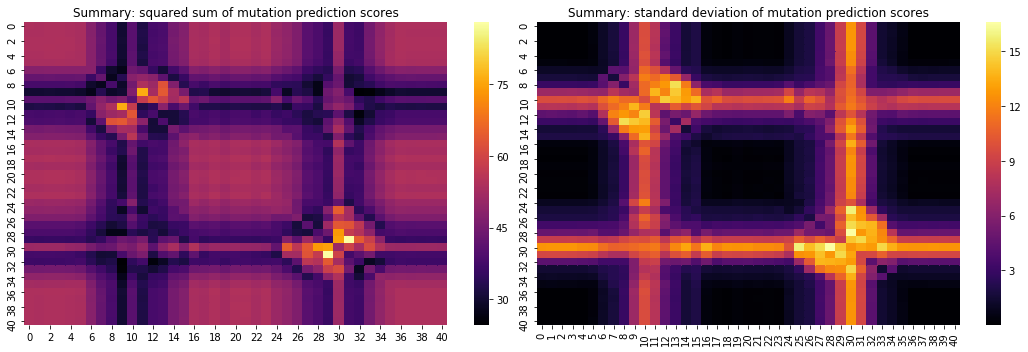

In [117]:
#Perform some sort of summary along the dims axis to plot in a heatmap

#Summarize the data in some way

mut2_sumlogits = np.sqrt(np.sum(mut2_predictlogits**2, axis=2))
#mut2_sumlogits = np.sum(np.abs(mut2_predictlogits), axis=2)
mut2_stdlogits = np.std(mut2_predictlogits, axis=2)


#Plot heatmaps of the data
plt.figure(figsize=(15,5))

#Plot all of the data
zoom1 = 0
zoom2 = X.shape[1]

plt.subplot(121)
plt.title('Summary: squared sum of mutation prediction scores')
sb.heatmap(mut2_sumlogits[zoom1:zoom2, zoom1:zoom2], cmap='inferno')
plt.subplot(122)
plt.title('Summary: standard deviation of mutation prediction scores')
sb.heatmap(mut2_stdlogits[zoom1:zoom2, zoom1:zoom2], cmap='inferno')

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


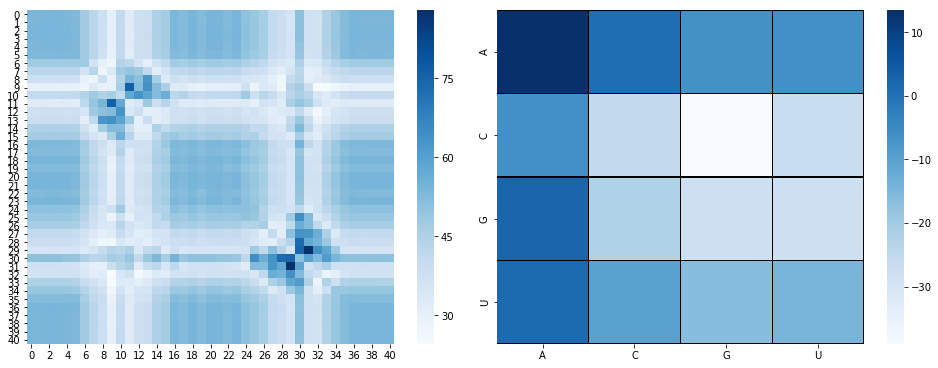

In [118]:
nuc = ['A', 'C', 'G', 'U']

fig4 = plt.figure(figsize=(20,10))
ax = fig4.add_subplot(2,3,1)
ax = sb.heatmap(mut2_sumlogits, cmap='Blues', yticklabels=1)

ax = fig4.add_subplot(2,3,2)
ax = sb.heatmap(mut2_predictlogits_hol[9, 11], cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=nuc)


/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


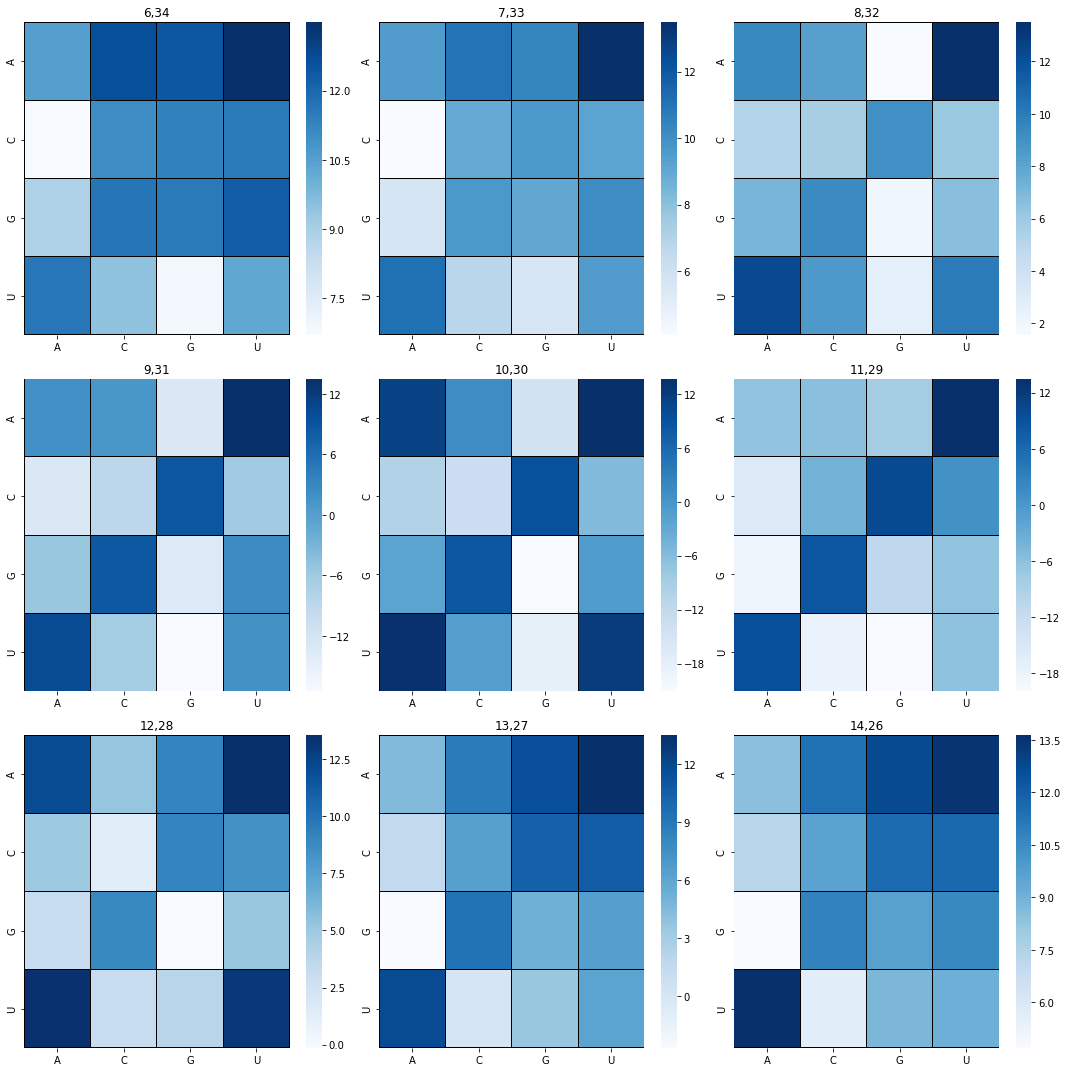

In [85]:
nuc = ['A', 'C', 'G', 'U']

fig4 = plt.figure(figsize=(15,15))

num = 9

for ii in range(9):
    ax = fig4.add_subplot(3,3,ii+1)
    ax.set_title(str(6+ii)+','+str(34-ii))
    ax = sb.heatmap(mut2_predictlogits_hol[6+ii, 34-ii],  cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=nuc)



In [82]:
mut2_predictlogits_hol[12, 28]

array([[ 12.11779976,   5.27179718,   9.13774395,  13.53785038],
       [  5.02528667,   1.38651991,   9.12693691,   8.3630476 ],
       [  3.20448184,   8.86882401,  -0.13697052,   5.19560814],
       [ 13.48263931,   3.22775126,   3.89768624,  13.06490803]], dtype=float32)

In [ ]:
vmin=0.95, vmax=1

In [18]:
#Look at the outputs

#Reshape into its organization L*L*mutations
mut2_predictoutputs = mut2_predictoutputs.reshape(X.shape[1],X.shape[1],16)
#Reshape into a holistic tensor organizing the mutations into 4*4
mut2_predictoutputs_hol = mut2_predictoutputs.reshape(X.shape[1],X.shape[1],4,4)

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


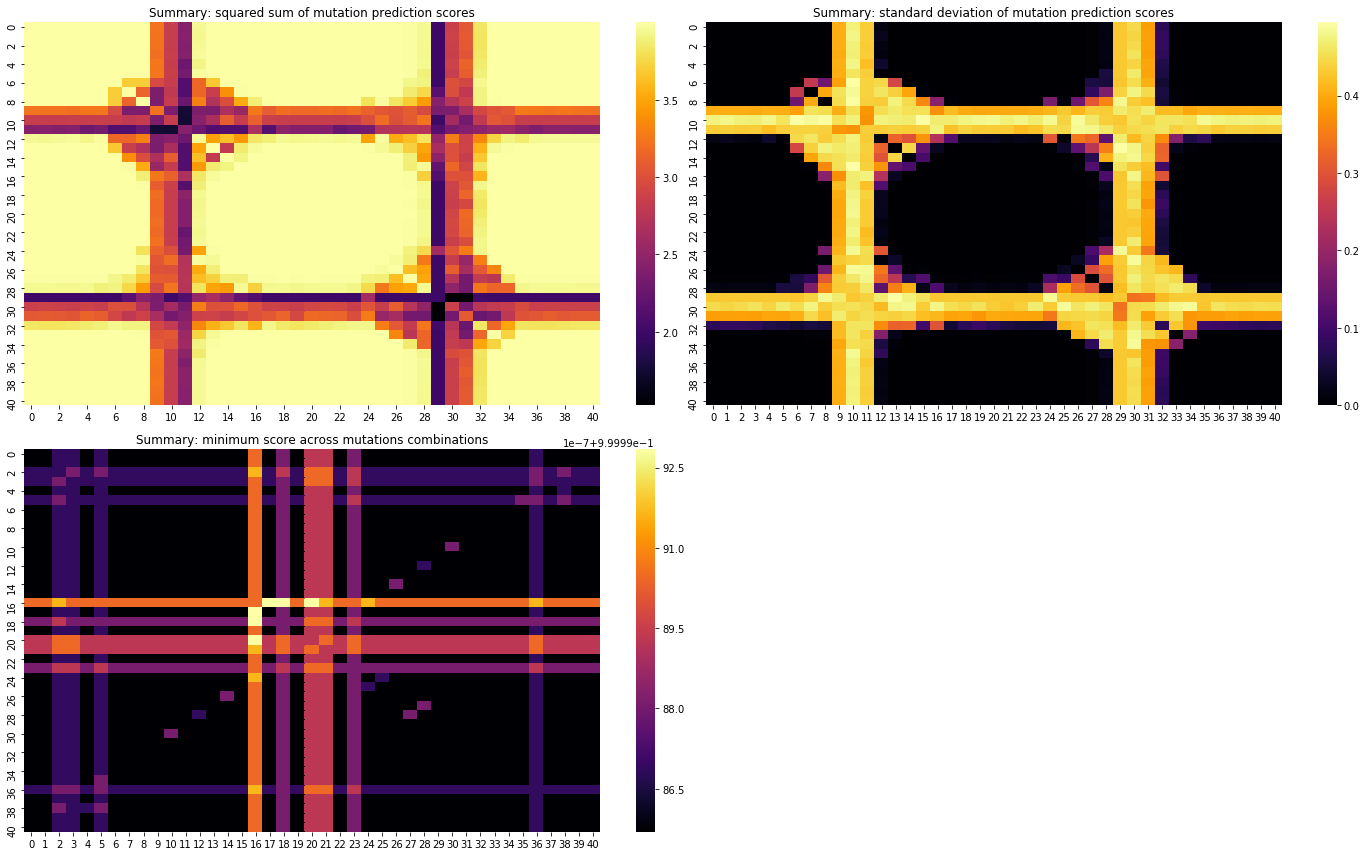

In [19]:
#Perform some sort of summary along the dims axis to plot in a heatmap

#Summarize the data in some way
mut2_sumoutputs = np.sqrt(np.sum(mut2_predictoutputs**2, axis=2))
mut2_stdoutputs = np.std(mut2_predictoutputs, axis=2)
mut2_maxoutputs = np.max(mut2_predictoutputs, axis=2)

#Plot heatmaps of the data
plt.figure(figsize=(20,12))

#Plot all of the data
zoom1 = 0
zoom2 = X.shape[1]

plt.subplot(221)
plt.title('Summary: squared sum of mutation prediction scores')
sb.heatmap(mut2_sumoutputs[zoom1:zoom2, zoom1:zoom2], cmap='inferno')
plt.subplot(222)
plt.title('Summary: standard deviation of mutation prediction scores')
sb.heatmap(mut2_stdoutputs[zoom1:zoom2, zoom1:zoom2], cmap='inferno')
plt.subplot(223)
plt.title('Summary: minimum score across mutations combinations')
sb.heatmap(mut2_maxoutputs[zoom1:zoom2, zoom1:zoom2], cmap='inferno')

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


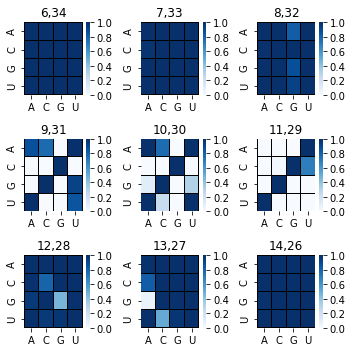

In [106]:
nuc = ['A', 'C', 'G', 'U']

fig4 = plt.figure(figsize=(5,5))

num = 9

for ii in range(9):
    ax = fig4.add_subplot(3,3,ii+1)
    ax.set_title(str(6+ii)+','+str(34-ii))
    ax = sb.heatmap(mut2_predictoutputs_hol[6+ii, 34-ii], vmin=0., vmax=1., cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=nuc)


/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


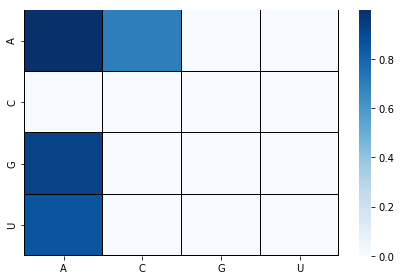

In [119]:
ax = fig4.add_subplot(2,3,2)
ax = sb.heatmap(mut2_predictoutputs_hol[9, 11], cmap='Blues', linewidths=0.1, linecolor='black', xticklabels=nuc, yticklabels=nuc)



In [16]:
min(mut2_predictoutputs)

array([  2.97876334e-20], dtype=float32)

In [ ]:
# initialize session
sess = utils.initialize_session()

# set best parameters
nntrainer.set_best_parameters(sess)

# plot first layer filters
W = nnmodel.get_parameters(sess, layer='conv1d_0')[0]


In [7]:
W.shape

(12, 1, 4, 96)